# Installs

In [1]:
# import sys

# !pip install --prefix {sys.prefix} tensorflow

In [2]:
# import sys

# !pip install --prefix {sys.prefix} scikit-learn

In [3]:
# conda install scikit-image

# Imports

In [61]:
import pickle
from PIL import Image 
from skimage import io
import random
import pandas as pd
import pymongo
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.model_selection import cross_val_score
from sklearn import tree
import numpy as np
import os

import requests
from io import BytesIO

# Connect to MongoDB

In [5]:
user = ""
pswd = ""

## Personal Account

In [6]:
# client = pymongo.MongoClient("mongodb+srv://{}:{}@cluster0.ihx5p.mongodb.net/<dbname>?retryWrites=true&w=majority".format(user, pswd))
# db = client["DATA_603"]
# collection = db["test_images"]

## School Account

In [7]:
client = pymongo.MongoClient("mongodb+srv://{}:{}@cluster0.x6cn9.mongodb.net/DATA_603?retryWrites=true&w=majority".format(user, pswd))
db = client["DATA_603"]
# collection = db["images"]

# Reading in data from school MongoDB Account

In [8]:
arr = []
for i in range(56):
    try:
        temp = pd.DataFrame(db["images_{}".format(i)].find({}))
        temp["numpy_arr"] = temp["numpy_arr"].apply(lambda x: pickle.loads(x))
        temp["numpy_arr"] = temp["numpy_arr"].apply(lambda x: Image.fromarray(x, 'RGB'))    
        arr.append(temp)
    except:
        # display(temp)
        continue
        
    if i % 5 == 0 and i < 50:
        print("{}%".format(2*i), end ="... ")
    if i == 50:
        print("Finished Loading")
        
        
df_all = pd.concat(arr, ignore_index=True)
display(df_all)    

0%... 10%... 20%... 30%... 40%... 50%... 60%... 70%... 80%... 90%... Finished Loading


,_id,source_url,numpy_arr,target,hand_labled_target
0,Extra_0,https://image.shutterstock.com/image-photo/smi...,<PIL.Image.Image image mode=RGB size=150x150 a...,No Mask,No Mask
1,Extra_1,https://image.shutterstock.com/image-photo/you...,<PIL.Image.Image image mode=RGB size=150x150 a...,No Mask,No Mask
2,Extra_2,https://image.shutterstock.com/image-photo/smi...,<PIL.Image.Image image mode=RGB size=150x150 a...,No Mask,No Mask
3,Extra_3,https://image.shutterstock.com/image-photo/mus...,<PIL.Image.Image image mode=RGB size=150x150 a...,No Mask,No Mask
4,Extra_4,https://image.shutterstock.com/image-photo/fin...,<PIL.Image.Image image mode=RGB size=150x150 a...,No Mask,No Mask
...,...,...,...,...,...
2222,No_Mask_1095,https://image.shutterstock.com/image-photo/sup...,<PIL.Image.Image image mode=RGB size=150x150 a...,No Mask,NaN
2223,No_Mask_1096,https://image.shutterstock.com/image-photo/sup...,<PIL.Image.Image image mode=RGB size=150x150 a...,No Mask,NaN
2224,No_Mask_1097,https://image.shutterstock.com/image-photo/sup...,<PIL.Image.Image image mode=RGB size=150x150 a...,No Mask,NaN
2225,No_Mask_1098,https://image.shutterstock.com/image-photo/clu...,<PIL.Image.Image image mode=RGB size=150x150 a...,No Mask,NaN


In [9]:
df = df_all[df_all["hand_labled_target"].notna()]

# Resizing Options
https://www.geeksforgeeks.org/python-pil-image-crop-method/

In [10]:
# Reduce data
# h = (8/10)*h_old = (4/5)*h_old
# w = (8/10)*w_old = (4/5)*h_old
# a = (16/25)*a_old = .64*a_old = (1 - .36)*a_old
def my_crop(x):       
    w, h = x.size 
    h2 = int(h*.9)

    left = (1/2)*(w - h2)
    top = 0
    right = w - (1/2)*(w - h2)
    bottom = h2

    return x.crop((left, top, right, bottom))

# df["numpy_arr"] = df["numpy_arr"].apply(lambda x: my_crop(x))

# Rerformat Images (Crop, grayscale, fixed size)
Ref: https://machinelearningmastery.com/how-to-load-and-manipulate-images-for-deep-learning-in-python-with-pil-pillow/

https://scikit-learn.org/0.15/auto_examples/cluster/plot_dict_face_patches.html

In [11]:
temp = pd.DataFrame()

temp["H"] = df["numpy_arr"].apply(lambda x: x.size[0])
temp["W"] = df["numpy_arr"].apply(lambda x: x.size[1])

print(temp.describe())
size = round(temp["H"].mean()), temp["W"].mean()
size = int(size[0]), int(size[1])
size

            H       W
count  1242.0  1242.0
mean    150.0   150.0
std       0.0     0.0
min     150.0   150.0
25%     150.0   150.0
50%     150.0   150.0
75%     150.0   150.0
max     150.0   150.0


(150, 150)

# Note, Incomming images will have to be reshaped to the same size

In [12]:
# Convert the image to grayscale
df["numpy_arr"] = df["numpy_arr"].apply(lambda x: x.convert(mode='L'))
# Resize Image
df["numpy_arr"] = df["numpy_arr"].apply(lambda x: x.resize(size))
# df["numpy_arr"] = df["numpy_arr"].apply(lambda x: x.resize((64,64))) # Currently looses too much information

<ipython-input-12-15234eaac0e6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["numpy_arr"] = df["numpy_arr"].apply(lambda x: x.convert(mode='L'))
<ipython-input-12-15234eaac0e6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["numpy_arr"] = df["numpy_arr"].apply(lambda x: x.resize(size))


# Flatten numpy arr and transform into columns

In [13]:
# Flatten Numpy Arr - cant convert into PIL Image
df["numpy_arr"] = df["numpy_arr"].apply(lambda x: np.array(x))

df["numpy_arr"] = df["numpy_arr"].apply(lambda x: x.flatten("F"))
# temp = df["numpy_arr"][0].reshape((334,280)).T # To undo 

# df["numpy_arr"] = df["numpy_arr"].apply(lambda x: x.flatten())
# temp = df["numpy_arr"][0].reshape((280,334)) # To undo
# Image.fromarray(temp)

<ipython-input-13-31c5b545c0c5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["numpy_arr"] = df["numpy_arr"].apply(lambda x: np.array(x))
<ipython-input-13-31c5b545c0c5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["numpy_arr"] = df["numpy_arr"].apply(lambda x: x.flatten("F"))


# Model doesn't do too bad on a binary classification

In [14]:
temp = df.copy()
# temp = temp[(temp["race"]=="African American") | (temp["race"]=="Native Hawaiian")]

X = pd.DataFrame(np.row_stack(temp.numpy_arr))
Y = np.array(temp.hand_labled_target)

X_train, X_test, Y_train, Y_test = train_test_split(X,
                                                    Y,
                                                    test_size=0.1,
                                                    shuffle=True,
                                                    random_state=2020)

In [15]:
model = tree.DecisionTreeClassifier(random_state=2020)
%time model = model.fit(X_train, Y_train)

print("Training data:", model.score(X_train, Y_train))
print("Testing data: ", model.score(X_test, Y_test))
print()
print("Max Depth:     ", model.get_depth())
print("Max Num Leaves:", model.get_n_leaves())
print()
print("df.shape:      ", df.shape)
print("X.shape:       ", X.shape)

CPU times: user 27 s, sys: 487 ms, total: 27.5 s
Wall time: 31.8 s
Training data: 1.0
Testing data:  0.68

Max Depth:      16
Max Num Leaves: 105

df.shape:       (1242, 5)
X.shape:        (1242, 22500)


# Grid Searching for best parameters

In [16]:
from sklearn.model_selection import GridSearchCV

parameters = {"criterion": ("gini", "entropy"), 
              "max_depth": range(10,20)}

model = tree.DecisionTreeClassifier(random_state=2020)
%time gcv = GridSearchCV(model, parameters, cv=5)
%time gcv.fit(X_train, Y_train)

CPU times: user 86 µs, sys: 175 µs, total: 261 µs
Wall time: 266 µs
CPU times: user 34min 37s, sys: 31.3 s, total: 35min 8s
Wall time: 41min 8s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=2020),
             param_grid={'criterion': ('gini', 'entropy'),
                         'max_depth': range(10, 20)})

In [59]:
grid = pd.DataFrame(gcv.cv_results_).sort_values('mean_test_score', ascending=False).T
grid

,10,15,1,0,11,19,12,16,18,13,17,4,5,2,6,8,7,3,14,9
mean_fit_time,21.1811,27.4655,24.6259,28.7671,20.4722,19.8948,22.3354,22.1213,23.2855,23.9835,24.9704,24.5242,26.9133,22.6808,26.9714,23.6961,28.4565,24.3812,23.9869,23.8146
std_fit_time,0.737667,7.44193,1.66828,5.17201,1.07699,0.935068,2.25816,1.66408,3.69525,5.13552,2.20108,2.19781,1.54124,0.795338,1.34958,1.85518,2.69848,0.925012,3.27144,1.79325
mean_score_time,0.169349,0.327642,0.252728,0.324759,0.177486,0.154662,0.174789,0.159506,0.175501,0.165607,0.229816,0.169563,0.203238,0.204283,0.235784,0.164809,0.242823,0.195944,0.175652,0.159421
std_score_time,0.0243109,0.154087,0.0445085,0.117478,0.0181586,0.0063972,0.0306528,0.0061513,0.0330645,0.00563597,0.12038,0.0104522,0.0383797,0.0208099,0.0666031,0.0229597,0.0717211,0.0396648,0.0184638,0.0100641
param_criterion,entropy,entropy,gini,gini,entropy,entropy,entropy,entropy,entropy,entropy,entropy,gini,gini,gini,gini,gini,gini,gini,entropy,gini
param_max_depth,10,15,11,10,11,19,12,16,18,13,17,14,15,12,16,18,17,13,14,19
params,"{'criterion': 'entropy', 'max_depth': 10}","{'criterion': 'entropy', 'max_depth': 15}","{'criterion': 'gini', 'max_depth': 11}","{'criterion': 'gini', 'max_depth': 10}","{'criterion': 'entropy', 'max_depth': 11}","{'criterion': 'entropy', 'max_depth': 19}","{'criterion': 'entropy', 'max_depth': 12}","{'criterion': 'entropy', 'max_depth': 16}","{'criterion': 'entropy', 'max_depth': 18}","{'criterion': 'entropy', 'max_depth': 13}","{'criterion': 'entropy', 'max_depth': 17}","{'criterion': 'gini', 'max_depth': 14}","{'criterion': 'gini', 'max_depth': 15}","{'criterion': 'gini', 'max_depth': 12}","{'criterion': 'gini', 'max_depth': 16}","{'criterion': 'gini', 'max_depth': 18}","{'criterion': 'gini', 'max_depth': 17}","{'criterion': 'gini', 'max_depth': 13}","{'criterion': 'entropy', 'max_depth': 14}","{'criterion': 'gini', 'max_depth': 19}"
split0_test_score,0.65625,0.616071,0.598214,0.584821,0.59375,0.616071,0.589286,0.616071,0.616071,0.629464,0.616071,0.59375,0.558036,0.5625,0.549107,0.553571,0.566964,0.549107,0.616071,0.566964
split1_test_score,0.598214,0.651786,0.620536,0.607143,0.602679,0.647321,0.638393,0.642857,0.647321,0.638393,0.660714,0.598214,0.602679,0.602679,0.611607,0.611607,0.611607,0.584821,0.616071,0.611607
split2_test_score,0.641256,0.650224,0.663677,0.672646,0.636771,0.623318,0.650224,0.618834,0.61435,0.600897,0.578475,0.668161,0.668161,0.663677,0.650224,0.654709,0.627803,0.650224,0.569507,0.618834


# Save Grid

In [62]:
grid.to_csv(os.path.join("Models", "Tree_Model_Mask_vs_No_Mask_Grid_CV.csv"))

In [18]:
model = tree.DecisionTreeClassifier(random_state=2020,
                                   criterion="entropy",
                                   max_depth=10)

%time model = model.fit(X_train, Y_train)

print("Training data:", model.score(X_train, Y_train))
print("Testing data: ", model.score(X_test, Y_test))
print()
print("Max Depth:     ", model.get_depth())
print("Max Num Leaves:", model.get_n_leaves())
print()
print("df.shape:      ", df.shape)
print("X.shape:       ", X.shape)

CPU times: user 22.9 s, sys: 226 ms, total: 23.1 s
Wall time: 24.2 s
Training data: 0.964189794091316
Testing data:  0.624

Max Depth:      10
Max Num Leaves: 69

df.shape:       (1242, 5)
X.shape:        (1242, 22500)


# Save Model

In [63]:
from joblib import dump, load

dump(model, os.path.join("Models", "Tree_Model_Mask_vs_No_Mask.joblib")) 

['Models/Tree_Model_Mask_vs_No_Mask.joblib']

# Useful Displays for Presenting

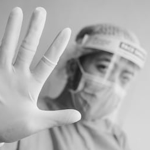

Target Label:            Mask
Predicted Lablel:        ['Mask']
Predicted Probablities:  [[0.7047619 0.2952381]]
Corresponding Labels:    ['Mask', 'No Mask']


In [24]:
for index in range(len(X_test)):
    #print(index), print(row)
    temp = X_test.iloc[index]
    temp = np.array(temp)

    img = temp.reshape(size).T 
    sample = temp.reshape(1, -1)

    display(Image.fromarray(img))

    print("Target Label:           ", Y_test[index])
    print("Predicted Lablel:       ", model.predict(sample))
    print("Predicted Probablities: ", model.predict_proba(sample))
    print("Corresponding Labels:   ", list(model.classes_))
    
    break

In [20]:
for i in range(len(Y_test)):
    print(i, Y_test[i])
    break

0 Mask


# Confusion Matrix

In [66]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_true = np.array(Y_test)
y_pred = np.array(model.predict(X_test))
cm = confusion_matrix(y_true, y_pred, labels=["Mask", "No Mask"])

cm

array([[64, 18],
       [29, 14]])

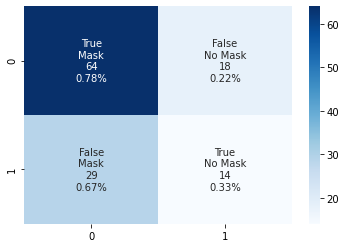

In [67]:
labels = [["True\nMask\n{}\n{}%".format( cm[0][0], round(cm[0][0]/cm[0].sum(), 2)) ,
           "False\nNo Mask\n{}\n{}%".format(   cm[0][1], round(cm[0][1]/cm[0].sum(), 2))],
          ["False\nMask\n{}\n{}%".format(cm[1][0], round(cm[1][0]/cm[1].sum(), 2)), 
           "True\nNo Mask\n{}\n{}%".format(    cm[1][1], round(cm[1][1]/cm[1].sum(), 2))]]
sns.heatmap(cm, annot=labels, fmt="", cmap="Blues")

In [65]:
from sklearn.metrics import precision_recall_fscore_support

precision_recall_fscore_support(y_true, y_pred)

(array([0.68817204, 0.4375    ]),
 array([0.7804878, 0.3255814]),
 array([0.73142857, 0.37333333]),
 array([82, 43]))

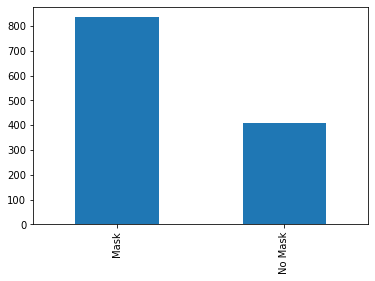

In [56]:
df["hand_labled_target"].value_counts().plot(kind="bar")

# Exploring Different ways to store image data

(391, 280)


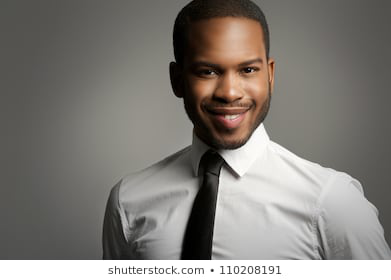

(391, 280)


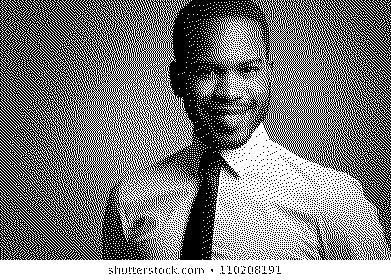

(252, 252)


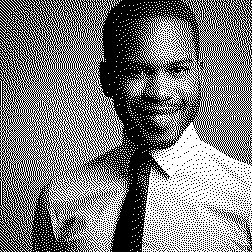

In [21]:
url = df["source_url"][31]

response = requests.get(url)
url_img = Image.open(BytesIO(response.content))

print(url_img.size)
display(url_img)

print(url_img.convert('1').size)
display(url_img.convert('1'))

print(my_crop(url_img).convert('1').size)
display(my_crop(url_img).convert('1'))

In [22]:
print("Default\t\t\t", 390*280*3)
print("Default converted\t", 390*280)
print("Default square converted", 280*280)
print("Default square converted", 260*260)
print("150 x 150 RBG\t\t", (150**2)*3)

Default			 327600
Default converted	 109200
Default square converted 78400
Default square converted 67600
150 x 150 RBG		 67500
